## Problem 1

Consider a convection/diffusion problem that has Dirichlet conditions on temperature imposed on both ends (see the figure below). This is an unusual problem that would be difficult to reproduce in a laboratory, but it is an interesting problem by which to observe the performance of advection schemes.

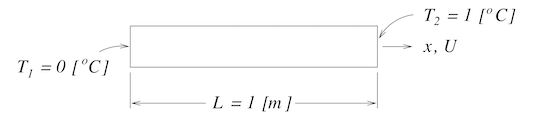
   
The exact solution to this problem is given by:

$$
    T(x)= T_1 + \frac{e^{x Pe/L} - 1}{e^{Pe} - 1}(T_2 - T_1)
$$

where $Pe$ is defined as $Pe= u L/\alpha$.  Solve this problem numerically for $Pe = 50$ by imposing:

- $L$ = 1 [m]
- $\rho$ = 1 [kg/m$^3$]
- $c_p$ = 1 [J/kg$\cdot$K]
- $u$ = 1 [m/s]
- $k$ = 0.02 [[W/m$\cdot$K]]
- $T_1$ = 0 [$^\circ$C]
- $T_2$ = 1 [$^\circ$C]

Discretize the one-dimensional domain using 10 equal sized control-volumes.  Initialize the field variables as $T$ = 0.0 [K] and $u$ = 1 [m/s]. Then, carry out the following:

1. Solve the problem using UDS, CDS, and QUICK (use $\Delta t = 10^{10}$ [s]).  Modify the value of $\alpha_e$ on the domain boundaries such that the value of temperature on the face is equal to the specified boundary temperature.
2. Plot the results for $T$ for all cases along with the exact solution. Discuss your results.
4. Re-run the case using 20, 40 and 80 uniformly spaced control volumes.  Discuss your results.

# Class definition

In [1]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)

        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)

        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [2]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP


In [3]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

class RobinBc:
    """Class defining a Robin boundary condition"""
    
    def __init__(self, phi, grid, h, k, Tamb, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            h........... convection coefficient
            k........... thermal conductivity 
            Tamb........ ambient temperature
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._h = h
        self._k = k
        self._Tamb = Tamb
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1/(1+((self._h/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            return (1/(1+((self._h/self._k)*self._grid.dx_PE[-1])))
      
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")


In [4]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

class SurfaceConvectionModel:
    """Class defining a surface convection model"""

    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To

    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""

        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)

        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)

        return coeffs

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._cp*self._grid.vol*(self._T[1:-1]-self._Told[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._cp*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs

In [5]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [6]:
import numpy as np

class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[ncv] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [7]:
import numpy as np

class CentralDifferenceModel:
    """Class defining an central-difference advection model"""
    
    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""
        
         # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[ncv] = -1 
                
        # Calculate the east integration point values (including both boundaries)
        self._phie = 0.5*self._phi[0:-1] + 0.5*self._phi[1:] # CDS
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1] # CDS
        flux_e = self._cp*mdote[1:]*self._phie[1:]   # CDS
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients using UDS
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell using CDS (HOS)
        flux = flux_e - flux_w 

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [8]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining an QUICK advection model"""
    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""
        
         # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[ncv] = -1 
        
        # Calculate the east integration point values (including both boundaries)            
        for i in range(self._grid.ncv+1):
            if i == 0:
                self._phie[i] = self._phi[i]
            else:
                if self._Uhe[i] >= 0:
                    x_xP = (self._grid.xf[i] - self._grid.xP[i])
                    x_xE = (self._grid.xf[i] - self._grid.xP[i+1])
                    xW_xP = (self._grid.xP[i-1] - self._grid.xP[i])
                    xW_xE = (self._grid.xP[i-1] - self._grid.xP[i+1])
                    t1 = (((x_xP)*(x_xE))/((xW_xP)*(xW_xE)))* self._phi[i-1]
                    x_xW = (self._grid.xf[i] - self._grid.xP[i-1])
                    xP_xW = (self._grid.xP[i] - self._grid.xP[i-1])
                    xP_xE = (self._grid.xP[i] - self._grid.xP[i+1])
                    t2 = (((x_xW)*(x_xE))/((xP_xW)*(xP_xE)))* self._phi[i]
                    xE_xW = (self._grid.xP[i+1] - self._grid.xP[i-1])
                    xE_xP = (self._grid.xP[i+1] - self._grid.xP[i])
                    t3 = (((x_xW)*(x_xP))/((xE_xW)*(xE_xP)))* self._phi[i+1]
                    self._phie[i] = t1 + t2 + t3
                else:
                    x_xEE = (self._grid.xf[i] - self._grid.xP[i+2])
                    xP_xEE = (self._grid.xP[i] - self._grid.xP[i+2])
                    t1 = (((x_xE)*(x_xEE))/((xP_xE)*(xP_xEE)))* self._phi[i]
                    xE_xEE = (self._grid.xP[i+1] - self._grid.xP[i+2])
                    xEE_xP = (self._grid.xP[i+2] - self._grid.xP[i])
                    t2 = (((x_xP)*(x_xEE))/((xE_xP)*(xE_xEE)))* self._phi[i+1]
                    xEE_xE = (self._grid.xP[i+2] - self._grid.xP[i+1])
                    t3 = (((x_xP)*(x_xE))/((xEE_xP)*(xEE_xE)))* self._phi[i+2]
                    self._phie[i] = t1 + t2 + t3

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1] #phie[:-1] = Tw
        flux_e = self._cp*mdote[1:]*self._phie[1:]   #phie[1:]  = Te
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

## Solving with Upwind Differencing Scheme (UDS)
### 10 control volumes

In [9]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_uds_10 = grid.xP
T_uds_10 = T

# Analytical solution
Pe = 50
T1 = 273
T2 = 274
T_analytical_10 = T1 + (((np.exp((grid.xP*Pe)/lx)-1)/(np.exp((Pe))-1))*(T2-T1))


Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 3.8220000000000005; Avg. Resid. = 0.5466000000000002
Iteration = 1; Max. Resid. = 1.1597306458887673e-15; Avg. Resid. = 4.1387067226402995e-16


## 20 control volumes

In [10]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_uds_20 = grid.xP
T_uds_20 = T

# Analytical solution
Pe = 50
T1 = 273
T2 = 274
T_analytical_20 = T1 + (((np.exp((grid.xP*Pe)/lx)-1)/(np.exp((Pe))-1))*(T2-T1))


Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 4.914000000000001; Avg. Resid. = 0.2730999999999996
Iteration = 1; Max. Resid. = 1.6529526223848714e-15; Avg. Resid. = 4.414021395207757e-16


## 40 control volumes

In [11]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_uds_40 = grid.xP
T_uds_40 = T

# Analytical solution
Pe = 50
T1 = 273
T2 = 274
T_analytical_40 = T1 + (((np.exp((grid.xP*Pe)/lx)-1)/(np.exp((Pe))-1))*(T2-T1))

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 7.098000000000001; Avg. Resid. = 0.2185500000000004
Iteration = 1; Max. Resid. = 2.200138795406652e-15; Avg. Resid. = 7.454904701695344e-16


## 80 control volumes

In [12]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 80
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_uds_80 = grid.xP
T_uds_80 = T

# Analytical solution
Pe = 50
T1 = 273
T2 = 274
T_analytical_80 = T1 + (((np.exp((grid.xP*Pe)/lx)-1)/(np.exp((Pe))-1))*(T2-T1))

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 11.466000000000001; Avg. Resid. = 0.21867500000000045
Iteration = 1; Max. Resid. = 3.7635956049761826e-15; Avg. Resid. = 1.4791156690320794e-15


## Solving with Central Differencing Scheme (CDS)
### 10 control volumes

In [13]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = CentralDifferenceModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_cds_10 = grid.xP
T_cds_10 = T

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 2.4570000000000003; Avg. Resid. = 0.2731000000000002
Iteration = 1; Max. Resid. = 1.039791632052896; Avg. Resid. = 0.27287490335263265
Iteration = 2; Max. Resid. = 0.7170235674872584; Avg. Resid. = 0.1843970241211325
Iteration = 3; Max. Resid. = 0.958161019640838; Avg. Resid. = 0.23048268297778027
Iteration = 4; Max. Resid. = 1.1289350215533016; Avg. Resid. = 0.26811815351557383
Iteration = 5; Max. Resid. = 1.2845881351808464; Avg. Resid. = 0.3349967048617792
Iteration = 6; Max. Resid. = 1.66184656348954; Avg. Resid. = 0.41626279707841196
Iteration = 7; Max. Resid. = 2.010647013968487; Avg. Resid. = 0.5200647225975505
Iteration = 8; Max. Resid. = 2.5495424811444845; Avg. Resid. = 0.6498633008802119
Iteration = 9; Max. Resid. = 3.1670769538460344; Avg. Resid. = 0.8121579568444515


### 20 control volumes

In [14]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 20
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = CentralDifferenceModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_cds_20 = grid.xP
T_cds_20 = T

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 3.5490000000000004; Avg. Resid. = 0.2185500000000004
Iteration = 1; Max. Resid. = 1.2030357141672559; Avg. Resid. = 0.136593749985257
Iteration = 2; Max. Resid. = 0.27384259373418063; Avg. Resid. = 0.05114076963693394
Iteration = 3; Max. Resid. = 0.4069072427872749; Avg. Resid. = 0.031962979864897156
Iteration = 4; Max. Resid. = 0.1337469912321464; Avg. Resid. = 0.017335632811785365
Iteration = 5; Max. Resid. = 0.13294118758558246; Avg. Resid. = 0.010834753920077263
Iteration = 6; Max. Resid. = 0.0637165203352955; Avg. Resid. = 0.006567918930802201
Iteration = 7; Max. Resid. = 0.04722631441776759; Avg. Resid. = 0.004104896764276663
Iteration = 8; Max. Resid. = 0.02673727408099486; Avg. Resid. = 0.002549835265837956
Iteration = 9; Max. Resid. = 0.017740540541803965; Avg. Resid. = 0.0015936116472369504
Iteration = 10; Max. Resid. = 0.010709509084000686; Avg. Resid. = 0.000994797056060458
Iteration = 11; Max. Resid. = 0.00683

### 40 control volumes

In [15]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 20
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = CentralDifferenceModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_cds_40 = grid.xP
T_cds_40 = T

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 5.7330000000000005; Avg. Resid. = 0.21867500000000045
Iteration = 1; Max. Resid. = 1.3373611110220538; Avg. Resid. = 0.068335937498377
Iteration = 2; Max. Resid. = 0.21201923076967388; Avg. Resid. = 0.014729379506957862
Iteration = 3; Max. Resid. = 0.15462980816356978; Avg. Resid. = 0.006531667788310718
Iteration = 4; Max. Resid. = 0.02525601724804201; Avg. Resid. = 0.0013253785639881308
Iteration = 5; Max. Resid. = 0.015034842380687969; Avg. Resid. = 0.0007783236106201537
Iteration = 6; Max. Resid. = 0.003777341830361775; Avg. Resid. = 0.0001949966374043526
Iteration = 7; Max. Resid. = 0.0013921783534143876; Avg. Resid. = 9.917450480792526e-05
Iteration = 8; Max. Resid. = 0.0004491414159393854; Avg. Resid. = 2.8806128616211592e-05
Iteration = 9; Max. Resid. = 0.00016640801392872522; Avg. Resid. = 1.287517096245468e-05
Iteration = 10; Max. Resid. = 6.014419625443851e-05; Avg. Resid. = 4.496835019155926e-06
Iteration = 11; 

### 80 control volumes

In [16]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 80
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 20
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)
#east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = CentralDifferenceModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_cds_80 = grid.xP
T_cds_80 = T

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 10.101; Avg. Resid. = 0.21873750000000042
Iteration = 1; Max. Resid. = 1.4050961537786437; Avg. Resid. = 0.03417773437456506
Iteration = 2; Max. Resid. = 0.14315476190489757; Avg. Resid. = 0.004221874418692238
Iteration = 3; Max. Resid. = 0.0488418510510887; Avg. Resid. = 0.001119748090518352
Iteration = 4; Max. Resid. = 0.004126692887366808; Avg. Resid. = 0.00011502472317677208
Iteration = 5; Max. Resid. = 0.0016161802417393528; Avg. Resid. = 4.565163591053614e-05
Iteration = 6; Max. Resid. = 0.00028868087947999126; Avg. Resid. = 6.913291919509132e-06
Iteration = 7; Max. Resid. = 6.82568906375903e-05; Avg. Resid. = 2.2389962509140915e-06
Iteration = 8; Max. Resid. = 1.6089256395692578e-05; Avg. Resid. = 4.6013511515050977e-07
Iteration = 9; Max. Resid. = 3.598129618528229e-06; Avg. Resid. = 1.2210943514345187e-07
Iteration = 10; Max. Resid. = 8.008616325018484e-07; Avg. Resid. = 2.7153021838879258e-08


## Solving with QUICK Scheme
### 10 control volumes

In [22]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_quick_10 = grid.xP
T_quick_10 = T


Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 4.732000000000001; Avg. Resid. = 0.7286000000000004
Iteration = 1; Max. Resid. = 0.9325697808142317; Avg. Resid. = 0.20894403002345613
Iteration = 2; Max. Resid. = 0.09156835861523943; Avg. Resid. = 0.034198625110489066
Iteration = 3; Max. Resid. = 0.03844142482978038; Avg. Resid. = 0.016090931322071407
Iteration = 4; Max. Resid. = 0.017559357382707436; Avg. Resid. = 0.006207079416332631
Iteration = 5; Max. Resid. = 0.007124810140597081; Avg. Resid. = 0.001996990435980928
Iteration = 6; Max. Resid. = 0.0027108063545402718; Avg. Resid. = 0.0008841693979829161
Iteration = 7; Max. Resid. = 0.0012714836182714689; Avg. Resid. = 0.0004145096174875087
Iteration = 8; Max. Resid. = 0.0004520038520575663; Avg. Resid. = 0.00016106633359998723
Iteration = 9; Max. Resid. = 0.0002124904928061764; Avg. Resid. = 6.700949015715988e-05


### 20 control volumes

In [23]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_quick_20 = grid.xP
T_quick_20 = T

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 5.824000000000001; Avg. Resid. = 0.36409999999999965
Iteration = 1; Max. Resid. = 0.8949537037108227; Avg. Resid. = 0.09168747637740762
Iteration = 2; Max. Resid. = 0.10299491200597437; Avg. Resid. = 0.01236215414693925
Iteration = 3; Max. Resid. = 0.02248418453765165; Avg. Resid. = 0.003082135063694245
Iteration = 4; Max. Resid. = 0.008632008167407354; Avg. Resid. = 0.0011643584204683692
Iteration = 5; Max. Resid. = 0.001471615833072661; Avg. Resid. = 0.0003345560433527497
Iteration = 6; Max. Resid. = 0.0004809592973727867; Avg. Resid. = 8.812070801887931e-05
Iteration = 7; Max. Resid. = 0.00017747345627223355; Avg. Resid. = 3.5562946519857564e-05
Iteration = 8; Max. Resid. = 4.561113482380364e-05; Avg. Resid. = 1.1759923419329773e-05
Iteration = 9; Max. Resid. = 1.3149028876562476e-05; Avg. Resid. = 3.568205222773213e-06


### 40 control volumes

In [24]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_quick_40 = grid.xP
T_quick_40 = T

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 8.008000000000001; Avg. Resid. = 0.26405000000000045
Iteration = 1; Max. Resid. = 0.8694907407401907; Avg. Resid. = 0.04491470550504952
Iteration = 2; Max. Resid. = 0.10038756111292213; Avg. Resid. = 0.006143123350052837
Iteration = 3; Max. Resid. = 0.012840003055678697; Avg. Resid. = 0.0012044897244844685
Iteration = 4; Max. Resid. = 0.004221635591596839; Avg. Resid. = 0.000342639049964934
Iteration = 5; Max. Resid. = 0.0007695433806365196; Avg. Resid. = 8.91798140097747e-05
Iteration = 6; Max. Resid. = 0.00014945369558488775; Avg. Resid. = 1.7995335848238366e-05
Iteration = 7; Max. Resid. = 4.098541745477373e-05; Avg. Resid. = 4.640887301248095e-06
Iteration = 8; Max. Resid. = 1.0474303624449655e-05; Avg. Resid. = 1.367196740855168e-06
Iteration = 9; Max. Resid. = 2.539300370573678e-06; Avg. Resid. = 3.8633381213608966e-07


### 80 control volumes

In [25]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 80
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 0.02

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0 
U0 = 1

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the advection model
advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_quick_80 = grid.xP
T_quick_80 = T


Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 12.376000000000001; Avg. Resid. = 0.24142500000000044
Iteration = 1; Max. Resid. = 0.8648611111109541; Avg. Resid. = 0.02244806177132652
Iteration = 2; Max. Resid. = 0.08318533911480153; Avg. Resid. = 0.002699107567054192
Iteration = 3; Max. Resid. = 0.007245602459847116; Avg. Resid. = 0.0004076105527214601
Iteration = 4; Max. Resid. = 0.0014742651870973547; Avg. Resid. = 7.788738667735456e-05
Iteration = 5; Max. Resid. = 0.0002889777715545112; Avg. Resid. = 1.4978554142455687e-05
Iteration = 6; Max. Resid. = 5.411047038262644e-05; Avg. Resid. = 2.6666834618641047e-06
Iteration = 7; Max. Resid. = 8.101164023748245e-06; Avg. Resid. = 4.1190731529904423e-07
Iteration = 8; Max. Resid. = 1.1988773171033243e-06; Avg. Resid. = 7.590237435908193e-08
Iteration = 9; Max. Resid. = 2.5322589294891965e-07; Avg. Resid. = 1.3253228456299418e-08


## Plotting the results for all three schemes 

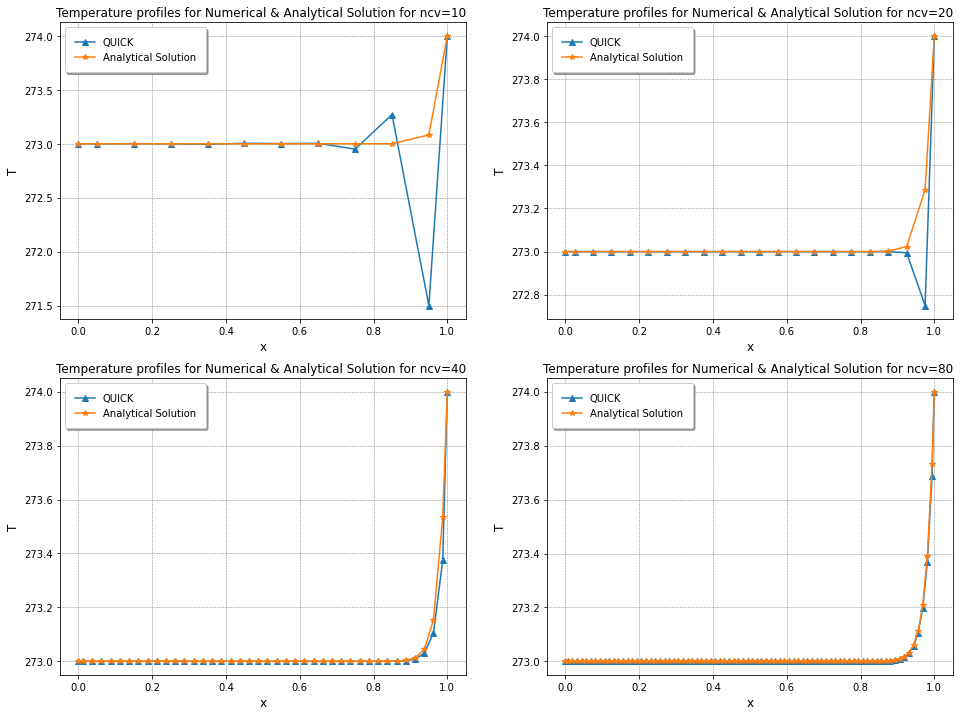

In [26]:
""" Plot for testing Accuracy of Numerical solution with Analytical solution """
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(16,12))
axes1 = fig.add_subplot(2,2,3)
axes2 = fig.add_subplot(2,2,4)
axes3 = fig.add_subplot(2,2,1)
axes4 = fig.add_subplot(2,2,2)


#axes1.plot(xp_uds_40, T_uds_40 , marker = "<", label = "UDS")
#axes1.plot(xp_cds_40, T_cds_40 , marker = "o", label = "CDS")
axes1.plot(xp_quick_40, T_quick_40 , marker = "^", label = "QUICK")
axes1.plot(xp_uds_40, T_analytical_40 , marker = "*", label = "Analytical Solution")
axes1.set_xlabel('x',fontsize = 12)
axes1.set_ylabel('T',fontsize = 12)
axes1.set_title('Temperature profiles for Numerical & Analytical Solution for ncv=40 ',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

#axes2.plot(xp_uds_80, T_uds_80 , marker = "<", label = "UDS")
#axes2.plot(xp_cds_80, T_cds_80 , marker = "o", label = "CDS")
axes2.plot(xp_quick_80, T_quick_80 , marker = "^", label = "QUICK")
axes2.plot(xp_uds_80, T_analytical_80 , marker = "*", label = "Analytical Solution")
axes2.set_xlabel('x',fontsize = 12)
axes2.set_ylabel('T',fontsize = 12)
axes2.set_title('Temperature profiles for Numerical & Analytical Solution for ncv=80 ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes2.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

#axes3.plot(xp_uds_10, T_uds_10 , marker = "<", label = "UDS")
#axes3.plot(xp_cds_10, T_cds_10 , marker = "o", label = "CDS")
axes3.plot(xp_quick_10, T_quick_10 , marker = "^", label = "QUICK")
axes3.plot(xp_uds_10, T_analytical_10 , marker = "*", label = "Analytical Solution")
axes3.set_xlabel('x',fontsize = 12)
axes3.set_ylabel('T',fontsize = 12)
axes3.set_title('Temperature profiles for Numerical & Analytical Solution for ncv=10 ',fontsize = 12)
axes3.grid(True)
axes3.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes3.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

#axes4.plot(xp_uds_20, T_uds_20 , marker = "<", label = "UDS")
#axes4.plot(xp_cds_20, T_cds_20 , marker = "o", label = "CDS")
axes4.plot(xp_quick_20, T_quick_20 , marker = "^", label = "QUICK")
axes4.plot(xp_uds_20, T_analytical_20 , marker = "*", label = "Analytical Solution")
axes4.set_xlabel('x',fontsize = 12)
axes4.set_ylabel('T',fontsize = 12)
axes4.set_title('Temperature profiles for Numerical & Analytical Solution for ncv=20 ',fontsize = 12)
axes4.grid(True)
axes4.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes4.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

### Discussion on Case (a)

### Discussion on Case (b), (c) and (d)